In [2]:
import pandas as pd
import numpy as np
from collections import Counter
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe,anneal
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import pygeohash as gh
#pca
#advesaary learning

In [3]:
train = pd.read_csv ('/home/jena/Downloads/ML/train.csv')
test = pd.read_csv ('/home/jena/Downloads/ML/test.csv')
sample_submission = pd.read_csv ('/home/jena/Downloads/ML/sample_submission.csv')
train_geo = pd.read_csv ('/home/jena/Downloads/ML/train_geo_updated.csv')
test_geo = pd.read_csv ('/home/jena/Downloads/ML/test_geo_updated.csv')

In [4]:
train['road_distance']=train_geo['road_distance']
test['road_distance']=test_geo['road_distance']
train['road_duration']=train_geo['road_duration']*60
test['road_duration']=test_geo['road_duration']*60
train['duration_in_traffic']=train_geo['duration_in_traffic']*60
test['duration_in_traffic']=test_geo['duration_in_traffic']*60


In [5]:
"""
x=train_geo['rows'].str.split(pat = ":",expand=True)
x[3]=x[3].str.slice(2,-10)
x[6]=x[6].str.slice(2,-10)
x[9]=x[9].str.slice(2,-10)
x[11]=x[11].str.slice(2,-5)
x['road_distance']=x[3]
x['road_duration']=x[6]
x['duration_in_traffic']=x[9]
x['status']=x[11]
x=x.drop([0,1,2,3,4,5,6,7,8,9,10,11],axis=1)
def status(row):
    if row['status'] =='OK':
        val = 1
    else:
        val = 0        
    return val

def road_distance(row):
    if 'm' in row['road_distance']:
        if 'km' in row['road_distance']:
            val=float(row['road_distance'][:-2])
        else:
            val=float(row['road_distance'][:-1])
    elif 'ft' in row['road_distance']:
        val=float(row['road_distance'][:-2])*0.3048
    return val

def road_duration(row):
    temp=[]
    if 'h' in row['road_duration']:
        temp=row['road_duration'].split('h')
        if len(temp[1])!=0:
            val=int(temp[0])*60+int(temp[1][:-3])
        else:
            val=int(temp[0][:-1])*60
    elif 'min' in row['road_duration']:
        val=int(row['road_duration'][:-3])
    else:
        val=0
    return val

def duration_in_traffic(row):
    temp=[]
    if 'hour' in row['duration_in_traffic']:
        temp=row['duration_in_traffic'].split('hour')
        if len(temp[1])!=0:
            val=int(temp[0])*60+int(temp[1][:-4])
        else:
            val=int(temp[0])*60
    elif 'mins' in row['duration_in_traffic']:
        val=int(row['duration_in_traffic'][:-4])
    else:
        val=0
    return val
x['status'] = x.apply(status, axis=1)
x['road_distance'] = x.apply(road_distance, axis=1)
x['road_duration'] = x.apply(road_duration, axis=1)
x['duration_in_traffic'] = x.apply(duration_in_traffic, axis=1)
"""

'\nx=train_geo[\'rows\'].str.split(pat = ":",expand=True)\nx[3]=x[3].str.slice(2,-10)\nx[6]=x[6].str.slice(2,-10)\nx[9]=x[9].str.slice(2,-10)\nx[11]=x[11].str.slice(2,-5)\nx[\'road_distance\']=x[3]\nx[\'road_duration\']=x[6]\nx[\'duration_in_traffic\']=x[9]\nx[\'status\']=x[11]\nx=x.drop([0,1,2,3,4,5,6,7,8,9,10,11],axis=1)\ndef status(row):\n    if row[\'status\'] ==\'OK\':\n        val = 1\n    else:\n        val = 0        \n    return val\n\ndef road_distance(row):\n    if \'m\' in row[\'road_distance\']:\n        if \'km\' in row[\'road_distance\']:\n            val=float(row[\'road_distance\'][:-2])\n        else:\n            val=float(row[\'road_distance\'][:-1])\n    elif \'ft\' in row[\'road_distance\']:\n        val=float(row[\'road_distance\'][:-2])*0.3048\n    return val\n\ndef road_duration(row):\n    temp=[]\n    if \'h\' in row[\'road_duration\']:\n        temp=row[\'road_duration\'].split(\'h\')\n        if len(temp[1])!=0:\n            val=int(temp[0])*60+int(temp[1][:

In [6]:
train["label"].replace({"correct": 1, "incorrect": 0}, inplace=True)

In [7]:
train.isnull().values.any()

True

In [8]:
#train[train['additional_fare'].isnull() & train['duration'].isnull() & train['meter_waiting'].isnull() & train['meter_waiting_fare'].isnull() & train['meter_waiting_till_pickup'].isnull() & train['fare'].isnull()]

In [9]:
#train = train.drop(train[train['additional_fare'].isnull() & train['duration'].isnull() & train['meter_waiting'].isnull() & train['meter_waiting_fare'].isnull() & train['meter_waiting_till_pickup'].isnull() & train['fare'].isnull()].index)

In [10]:
null_columns=train.columns[train.isnull().any()]
train[null_columns].isnull().sum()

additional_fare              202
duration                     202
meter_waiting                202
meter_waiting_fare           202
meter_waiting_till_pickup    202
fare                         137
dtype: int64

In [11]:
counter = Counter(train['label'])
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)
counter

Estimate: 0.108


Counter({1: 15495, 0: 1681})

In [12]:
#df = pd.DataFrame(train)
#train1 = df.dropna(how='any',axis=0)
train1=train
#train1.fillna(train1.mean(), inplace=True)
train1['additional_fare'] = train1.groupby(['label'], sort=False)['additional_fare'].apply(lambda x: x.fillna(x.mean()))
train1['duration'] = train1.groupby(['label'], sort=False)['duration'].apply(lambda x: x.fillna(x.mean()))
train1['meter_waiting'] = train1.groupby(['label'], sort=False)['meter_waiting'].apply(lambda x: x.fillna(x.mean()))
train1['meter_waiting_fare'] = train1.groupby(['label'], sort=False)['meter_waiting_fare'].apply(lambda x: x.fillna(x.mean()))
train1['meter_waiting_till_pickup'] = train1.groupby(['label'], sort=False)['meter_waiting_till_pickup'].apply(lambda x: x.fillna(x.mean()))
train1['fare'] = train1.groupby(['label'], sort=False)['fare'].apply(lambda x: x.fillna(x.mean()))
"""
train1["additional_fare"] = train1.groupby("label").transform(lambda x: x.fillna(x.mean()))
train1["duration"] = train1.groupby("label").transform(lambda x: x.fillna(x.mean()))
train1["meter_waiting"] = train1.groupby("label").transform(lambda x: x.fillna(x.mean()))
train1["meter_waiting_fare"] = train1.groupby("label").transform(lambda x: x.fillna(x.mean()))
train1["meter_waiting_till_pickup"] = train1.groupby("label").transform(lambda x: x.fillna(x.mean()))
train1["fare"] = train1.groupby("label").transform(lambda x: x.fillna(x.mean()))
"""

'\ntrain1["additional_fare"] = train1.groupby("label").transform(lambda x: x.fillna(x.mean()))\ntrain1["duration"] = train1.groupby("label").transform(lambda x: x.fillna(x.mean()))\ntrain1["meter_waiting"] = train1.groupby("label").transform(lambda x: x.fillna(x.mean()))\ntrain1["meter_waiting_fare"] = train1.groupby("label").transform(lambda x: x.fillna(x.mean()))\ntrain1["meter_waiting_till_pickup"] = train1.groupby("label").transform(lambda x: x.fillna(x.mean()))\ntrain1["fare"] = train1.groupby("label").transform(lambda x: x.fillna(x.mean()))\n'

In [13]:
train1.isnull().values.any()

False

In [14]:
# count examples in each class
counter = Counter(train1['label'])
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)
counter

Estimate: 0.108


Counter({1: 15495, 0: 1681})

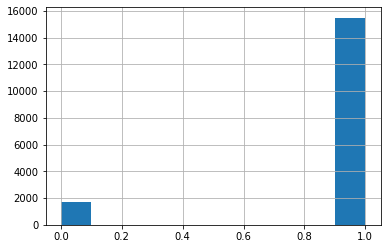

In [15]:
import matplotlib.pyplot as plt
train1['label'].hist()
#train1.groupby('label')['label'].plot(kind='bar')

In [16]:
train1.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,road_distance,road_duration,duration_in_traffic
0,189123628,10.50000,834.000000,56.000000,0.000000,64.000000,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,1,7.9,1500,1080
1,189125358,10.50000,791.000000,47.000000,0.000000,134.000000,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,1,5.2,960,840
2,189125719,10.50000,1087.000000,80.000000,0.000000,61.000000,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,1,9.2,1560,1200
3,189127273,10.50000,598.000000,271.000000,15.663800,68.000000,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,1,1.5,240,240
4,189128020,12.44434,1413.967232,356.655679,16.909938,107.549152,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,1,10.0,1740,1320


In [17]:
test.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,road_distance,road_duration,duration_in_traffic
0,213284604,10.5,924,42,2.4486,148,2/1/2020 0:38,2/1/2020 0:53,6.83454,79.8750,6.77490,79.8840,289.27,8.6,1320,840
1,213286352,10.5,4249,20,0.0000,91,2/1/2020 1:02,2/1/2020 2:13,6.91168,79.8723,6.55091,79.9706,1912.70,63.5,5040,4200
2,213293973,10.5,1552,255,2.6588,23,2/1/2020 5:02,2/1/2020 5:28,6.92145,79.8478,6.90539,79.8989,394.00,7.3,1560,1080
3,213294622,10.5,462,16,0.0000,198,2/1/2020 5:30,2/1/2020 5:38,6.77433,79.9416,6.80401,79.9407,154.32,4.0,600,420
4,213298687,10.5,814,392,12.3692,69,2/1/2020 7:00,2/1/2020 7:14,6.97968,79.9130,6.98875,79.8914,147.47,3.0,540,360


In [18]:
#sample_submission

In [19]:
train1.dtypes

tripid                         int64
additional_fare              float64
duration                     float64
meter_waiting                float64
meter_waiting_fare           float64
meter_waiting_till_pickup    float64
pickup_time                   object
drop_time                     object
pick_lat                     float64
pick_lon                     float64
drop_lat                     float64
drop_lon                     float64
fare                         float64
label                          int64
road_distance                float64
road_duration                  int64
duration_in_traffic            int64
dtype: object

In [20]:
df1 = pd.DataFrame(train1) 

In [21]:
train_x = df1.drop('label',axis=1)
train_y = df1['label']

In [22]:
train_x.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,road_distance,road_duration,duration_in_traffic
0,189123628,10.50000,834.000000,56.000000,0.000000,64.000000,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,7.9,1500,1080
1,189125358,10.50000,791.000000,47.000000,0.000000,134.000000,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,5.2,960,840
2,189125719,10.50000,1087.000000,80.000000,0.000000,61.000000,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,9.2,1560,1200
3,189127273,10.50000,598.000000,271.000000,15.663800,68.000000,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,1.5,240,240
4,189128020,12.44434,1413.967232,356.655679,16.909938,107.549152,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,10.0,1740,1320


In [23]:
train_x['real_duration']=train_x['duration']-train_x['meter_waiting']
train_x['real_fare']=train_x['fare']-train_x['additional_fare']-train_x['meter_waiting_fare']
test['real_duration']=test['duration']-test['meter_waiting']
test['real_fare']=test['fare']-test['additional_fare']-test['meter_waiting_fare']

In [24]:
import datetime as dt
def add_pickup_datetime_info(dataset,name):
    #Convert to datetime format
    dataset[name] = pd.to_datetime(dataset[name],format="%m/%d/%Y %H:%M")
    
    dataset[name+'_hour'] = dataset.pickup_time.dt.hour*60+dataset.pickup_time.dt.minute
    dataset[name+'_day'] = dataset.pickup_time.dt.day
    dataset[name+'_month'] = dataset.pickup_time.dt.month
    dataset[name+'_weekday'] = dataset.pickup_time.dt.weekday
    dataset[name+'_year'] = dataset.pickup_time.dt.year
    
    return dataset

In [25]:
def add_drop_datetime_info(dataset,name):
    #Convert to datetime format
    dataset[name] = pd.to_datetime(dataset[name],format="%m/%d/%Y %H:%M")
    
    dataset[name+'_hour'] = dataset.drop_time.dt.hour*60+dataset.drop_time.dt.minute
    dataset[name+'_day'] = dataset.drop_time.dt.day
    dataset[name+'_month'] = dataset.drop_time.dt.month
    dataset[name+'_weekday'] = dataset.drop_time.dt.weekday
    dataset[name+'_year'] = dataset.drop_time.dt.year
    
    return dataset

In [26]:
add_pickup_datetime_info(train_x,'pickup_time')
add_drop_datetime_info(train_x,'drop_time')
add_pickup_datetime_info(test,'pickup_time')
add_drop_datetime_info(test,'drop_time')
train_x.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,...,pickup_time_hour,pickup_time_day,pickup_time_month,pickup_time_weekday,pickup_time_year,drop_time_hour,drop_time_day,drop_time_month,drop_time_weekday,drop_time_year
0,189123628,10.50000,834.000000,56.000000,0.000000,64.000000,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,...,20,1,11,4,2019,34,1,11,4,2019
1,189125358,10.50000,791.000000,47.000000,0.000000,134.000000,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,...,56,1,11,4,2019,69,1,11,4,2019
2,189125719,10.50000,1087.000000,80.000000,0.000000,61.000000,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,...,68,1,11,4,2019,86,1,11,4,2019
3,189127273,10.50000,598.000000,271.000000,15.663800,68.000000,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,...,147,1,11,4,2019,157,1,11,4,2019
4,189128020,12.44434,1413.967232,356.655679,16.909938,107.549152,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,...,214,1,11,4,2019,231,1,11,4,2019


In [27]:
test.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,...,pickup_time_hour,pickup_time_day,pickup_time_month,pickup_time_weekday,pickup_time_year,drop_time_hour,drop_time_day,drop_time_month,drop_time_weekday,drop_time_year
0,213284604,10.5,924,42,2.4486,148,2020-02-01 00:38:00,2020-02-01 00:53:00,6.83454,79.8750,...,38,1,2,5,2020,53,1,2,5,2020
1,213286352,10.5,4249,20,0.0000,91,2020-02-01 01:02:00,2020-02-01 02:13:00,6.91168,79.8723,...,62,1,2,5,2020,133,1,2,5,2020
2,213293973,10.5,1552,255,2.6588,23,2020-02-01 05:02:00,2020-02-01 05:28:00,6.92145,79.8478,...,302,1,2,5,2020,328,1,2,5,2020
3,213294622,10.5,462,16,0.0000,198,2020-02-01 05:30:00,2020-02-01 05:38:00,6.77433,79.9416,...,330,1,2,5,2020,338,1,2,5,2020
4,213298687,10.5,814,392,12.3692,69,2020-02-01 07:00:00,2020-02-01 07:14:00,6.97968,79.9130,...,420,1,2,5,2020,434,1,2,5,2020


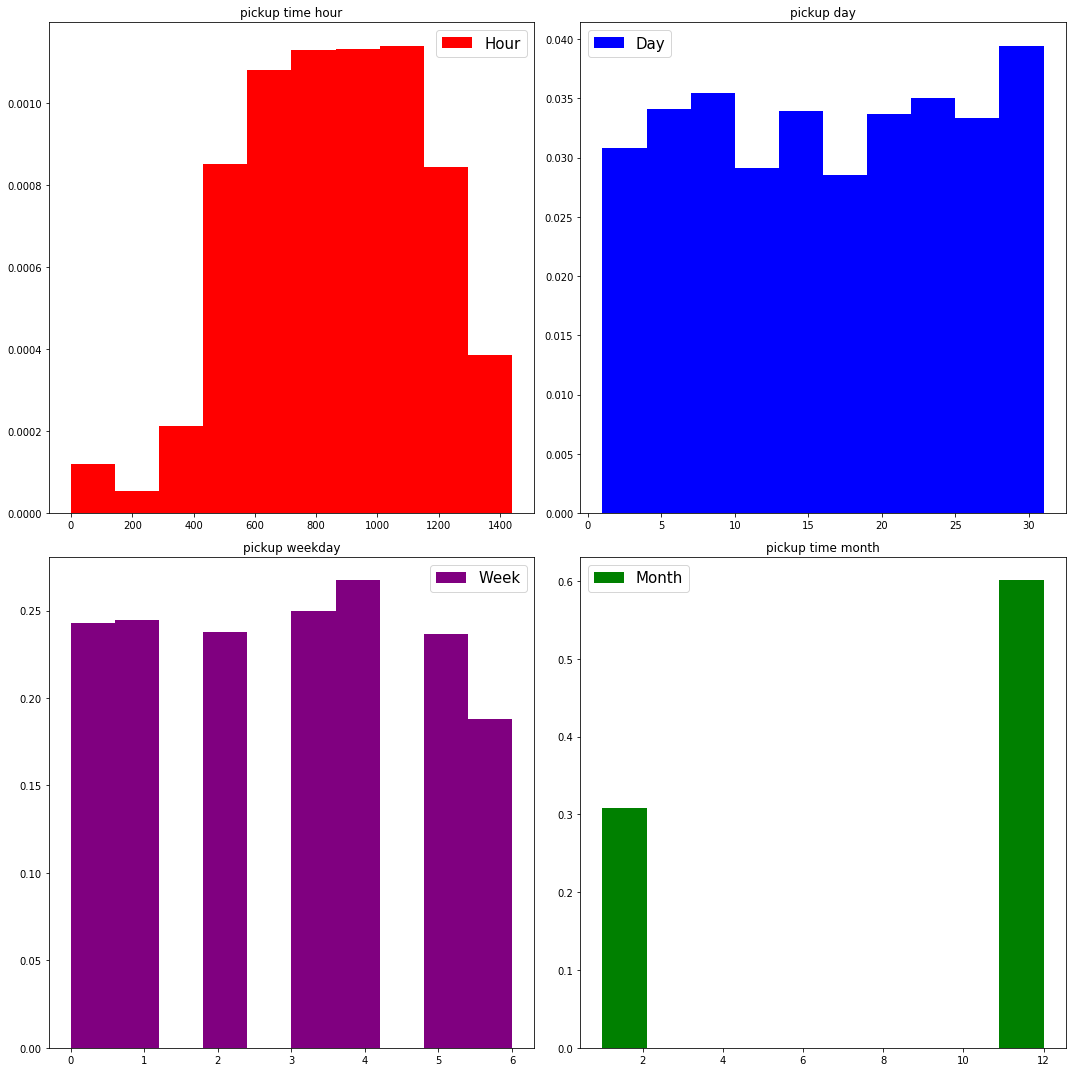

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15, 15))
ax0, ax1, ax2, ax3 = axes.flatten()
n_bins = 10
colors = ['red']
ax0.hist(train_x['pickup_time_hour'], n_bins, density=True, histtype='bar', color=colors, label='Hour')
ax0.legend(prop={'size': 15})
ax0.set_title('pickup time hour')

colors = ['blue']
ax1.hist(train_x['pickup_time_day'], n_bins, density=True, histtype='bar', color=colors, label='Day')
ax1.legend(prop={'size': 15})
ax1.set_title('pickup day')

colors = ['purple']
ax2.hist(train_x['pickup_time_weekday'], n_bins, density=True, histtype='bar', color=colors, label='Week')
ax2.legend(prop={'size': 15})
ax2.set_title('pickup weekday')

colors = ['green']
ax3.hist(train_x['pickup_time_month'], n_bins, density=True, histtype='bar', color=colors, label='Month')
ax3.legend(prop={'size': 15})
ax3.set_title('pickup time month')


fig.tight_layout()
plt.show()

In [29]:
def weekday(row):
    if row['pickup_time_weekday'] <5:
        val = 1
    else:
        val = 0
    return val

In [30]:
def peek_time(row):
    if row['pickup_time_hour'] >=5*60 and row['pickup_time_hour']< 12*60:
        val = 'Morning'
    elif row['pickup_time_hour'] >=12*60 and row['pickup_time_hour']< 17*60:
        val = 'Afternoon'
    elif row['pickup_time_hour'] >=17*60 and row['pickup_time_hour']< 21*60:
        val = 'Evening'
    else:
        val = 'Night'
    return val

In [31]:
#train_x['weekday'] = train_x.apply(weekday, axis=1)
#train_x['day'] = train_x.apply(peek_time, axis=1)
#test['weekday'] = train_x.apply(weekday, axis=1)
#test['day'] = train_x.apply(peek_time, axis=1)
train_x.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,...,pickup_time_hour,pickup_time_day,pickup_time_month,pickup_time_weekday,pickup_time_year,drop_time_hour,drop_time_day,drop_time_month,drop_time_weekday,drop_time_year
0,189123628,10.50000,834.000000,56.000000,0.000000,64.000000,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,...,20,1,11,4,2019,34,1,11,4,2019
1,189125358,10.50000,791.000000,47.000000,0.000000,134.000000,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,...,56,1,11,4,2019,69,1,11,4,2019
2,189125719,10.50000,1087.000000,80.000000,0.000000,61.000000,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,...,68,1,11,4,2019,86,1,11,4,2019
3,189127273,10.50000,598.000000,271.000000,15.663800,68.000000,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,...,147,1,11,4,2019,157,1,11,4,2019
4,189128020,12.44434,1413.967232,356.655679,16.909938,107.549152,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,...,214,1,11,4,2019,231,1,11,4,2019


In [32]:
train_x=train_x.drop(['pickup_time','drop_time','pickup_time_weekday','pickup_time_hour','pickup_time_day','pickup_time_month','drop_time_hour','pickup_time_year','drop_time_day','drop_time_month','drop_time_weekday','drop_time_year'],axis=1)
#train_x = pd.get_dummies(train_x, columns=['day'], prefix = ['day'])
#train_x = pd.get_dummies(train_x, columns=['pickup_time_weekday'], prefix = ['weekday'])
#train_x = pd.get_dummies(train_x, columns=['pickup_time_hour'], prefix = ['pickup_hour'])
#train_x = pd.get_dummies(train_x, columns=['drop_time_hour'], prefix = ['drop_hour'])
#train_x = pd.get_dummies(train_x, columns=['drop_time_year'], prefix = ['year'])

test=test.drop(['pickup_time','drop_time','pickup_time_weekday','pickup_time_hour','pickup_time_day','pickup_time_month','pickup_time_year','drop_time_day','drop_time_month','drop_time_weekday','drop_time_year','drop_time_hour'],axis=1)
#test = pd.get_dummies(test, columns=['day'], prefix = ['day'])
#test = pd.get_dummies(test, columns=['pickup_time_weekday'], prefix = ['weekday'])
#test = pd.get_dummies(test, columns=['pickup_time_hour'], prefix = ['pickup_hour'])
#test = pd.get_dummies(test, columns=['drop_time_hour'], prefix = ['drop_hour'])
#train_x = pd.get_dummies(train_x, columns=['drop_time_year'], prefix = ['year'])
#test = pd.get_dummies(test, columns=['drop_time_year'], prefix = ['year'])


In [33]:
train_x.dtypes

tripid                         int64
additional_fare              float64
duration                     float64
meter_waiting                float64
meter_waiting_fare           float64
meter_waiting_till_pickup    float64
pick_lat                     float64
pick_lon                     float64
drop_lat                     float64
drop_lon                     float64
fare                         float64
road_distance                float64
road_duration                  int64
duration_in_traffic            int64
real_duration                float64
real_fare                    float64
dtype: object

In [34]:
train_x.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,road_distance,road_duration,duration_in_traffic,real_duration,real_fare
0,189123628,10.50000,834.000000,56.000000,0.000000,64.000000,6.86252,79.8993,6.90330,79.8783,270.32,7.9,1500,1080,778.000000,259.820000
1,189125358,10.50000,791.000000,47.000000,0.000000,134.000000,6.88589,79.8984,6.91373,79.8923,197.85,5.2,960,840,744.000000,187.350000
2,189125719,10.50000,1087.000000,80.000000,0.000000,61.000000,6.90839,79.8651,6.93669,79.9146,301.64,9.2,1560,1200,1007.000000,291.140000
3,189127273,10.50000,598.000000,271.000000,15.663800,68.000000,6.92570,79.8895,6.92748,79.8971,82.30,1.5,240,240,327.000000,56.136200
4,189128020,12.44434,1413.967232,356.655679,16.909938,107.549152,6.87441,79.8615,6.84478,79.9290,358.39,10.0,1740,1320,1057.311553,329.035722


In [35]:
test.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,road_distance,road_duration,duration_in_traffic,real_duration,real_fare
0,213284604,10.5,924,42,2.4486,148,6.83454,79.8750,6.77490,79.8840,289.27,8.6,1320,840,882,276.3214
1,213286352,10.5,4249,20,0.0000,91,6.91168,79.8723,6.55091,79.9706,1912.70,63.5,5040,4200,4229,1902.2000
2,213293973,10.5,1552,255,2.6588,23,6.92145,79.8478,6.90539,79.8989,394.00,7.3,1560,1080,1297,380.8412
3,213294622,10.5,462,16,0.0000,198,6.77433,79.9416,6.80401,79.9407,154.32,4.0,600,420,446,143.8200
4,213298687,10.5,814,392,12.3692,69,6.97968,79.9130,6.98875,79.8914,147.47,3.0,540,360,422,124.6008


In [36]:
train_x.dtypes

tripid                         int64
additional_fare              float64
duration                     float64
meter_waiting                float64
meter_waiting_fare           float64
meter_waiting_till_pickup    float64
pick_lat                     float64
pick_lon                     float64
drop_lat                     float64
drop_lon                     float64
fare                         float64
road_distance                float64
road_duration                  int64
duration_in_traffic            int64
real_duration                float64
real_fare                    float64
dtype: object

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,road_distance,road_duration,duration_in_traffic,real_duration,real_fare
count,1.717600e+04,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000
mean,2.014549e+08,13.827228,1727.227196,652.053845,33.335438,112.881658,6.965499,79.998389,6.968587,79.997534,315.459455,40.942151,979.279227,753.800652,1075.173351,268.296788
std,7.456830e+06,98.398546,8076.802120,8019.763794,462.955614,439.471700,0.210760,0.243384,0.378669,0.359648,603.692067,150.739523,769.654009,592.855115,1978.199092,292.978337
min,1.891236e+08,0.000000,0.000000,0.000000,0.000000,0.000000,5.937600,79.819100,5.941860,45.307700,0.000000,0.000000,0.000000,0.000000,-210124.000000,-192.895537
25%,1.947619e+08,10.500000,552.000000,33.000000,0.000000,26.000000,6.865077,79.870400,6.865625,79.870100,125.960000,3.100000,420.000000,360.000000,449.000000,107.415375
50%,2.013582e+08,10.500000,1027.000000,128.000000,0.233200,74.000000,6.914105,79.898600,6.916160,79.899100,213.010000,5.700000,780.000000,600.000000,823.000000,189.139100
75%,2.083081e+08,10.500000,1831.000000,361.000000,15.317000,146.000000,7.043057,79.956600,7.047195,79.960225,371.740000,10.500000,1380.000000,1080.000000,1392.250000,336.389531
max,2.138173e+08,12795.030000,453872.000000,453650.000000,26198.601400,51288.000000,8.051010,81.009600,48.132000,81.009700,26945.990000,999.000000,10380.000000,9000.000000,46609.000000,13678.756200


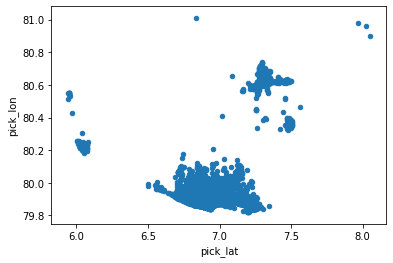

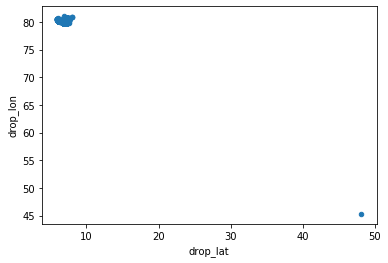

In [37]:
#Plot variables using only 1000 rows for efficiency
train_x.plot.scatter('pick_lat', 'pick_lon')
train_x.plot.scatter('drop_lat', 'drop_lon')

#Get distribution of values
train_x.describe()


In [38]:
def sphere_dist(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    """
    Return distance along great radius between pickup and dropoff coordinates.
    """
    #Define earth radius (km)
    R_earth = 6371
    #Convert degrees to radians
    pickup_lat, pickup_lon, dropoff_lat, dropoff_lon = map(np.radians,
                                                             [pickup_lat, pickup_lon, 
                                                              dropoff_lat, dropoff_lon])
    #Compute distances along lat, lon dimensions
    dlat = dropoff_lat - pickup_lat
    dlon = dropoff_lon - pickup_lon
    
    #Compute haversine distance
    a = np.sin(dlat/2.0)**2 + np.cos(pickup_lat) * np.cos(dropoff_lat) * np.sin(dlon/2.0)**2
    
    return 2 * R_earth * np.arcsin(np.sqrt(a))

In [39]:
test.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,road_distance,road_duration,duration_in_traffic,real_duration,real_fare
0,213284604,10.5,924,42,2.4486,148,6.83454,79.8750,6.77490,79.8840,289.27,8.6,1320,840,882,276.3214
1,213286352,10.5,4249,20,0.0000,91,6.91168,79.8723,6.55091,79.9706,1912.70,63.5,5040,4200,4229,1902.2000
2,213293973,10.5,1552,255,2.6588,23,6.92145,79.8478,6.90539,79.8989,394.00,7.3,1560,1080,1297,380.8412
3,213294622,10.5,462,16,0.0000,198,6.77433,79.9416,6.80401,79.9407,154.32,4.0,600,420,446,143.8200
4,213298687,10.5,814,392,12.3692,69,6.97968,79.9130,6.98875,79.8914,147.47,3.0,540,360,422,124.6008


In [40]:
train_x['distance'] = sphere_dist(train_x['pick_lat'], train_x['pick_lon'],train_x['drop_lat'], train_x['drop_lon'])
test['distance'] = sphere_dist(test['pick_lat'], test['pick_lon'],test['drop_lat'], test['drop_lon'])

In [41]:
train_x.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,road_distance,road_duration,duration_in_traffic,real_duration,real_fare,distance
0,189123628,10.50000,834.000000,56.000000,0.000000,64.000000,6.86252,79.8993,6.90330,79.8783,270.32,7.9,1500,1080,778.000000,259.820000,5.092770
1,189125358,10.50000,791.000000,47.000000,0.000000,134.000000,6.88589,79.8984,6.91373,79.8923,197.85,5.2,960,840,744.000000,187.350000,3.168058
2,189125719,10.50000,1087.000000,80.000000,0.000000,61.000000,6.90839,79.8651,6.93669,79.9146,301.64,9.2,1560,1200,1007.000000,291.140000,6.305395
3,189127273,10.50000,598.000000,271.000000,15.663800,68.000000,6.92570,79.8895,6.92748,79.8971,82.30,1.5,240,240,327.000000,56.136200,0.861946
4,189128020,12.44434,1413.967232,356.655679,16.909938,107.549152,6.87441,79.8615,6.84478,79.9290,358.39,10.0,1740,1320,1057.311553,329.035722,8.147782


In [42]:
"""
train_x['pick_geohash']=train_x.apply(lambda x: gh.encode(x.pick_lat, x.pick_lon, precision=5), axis=1)
train_x['drop_geohash']=train_x.apply(lambda x: gh.encode(x.drop_lat, x.drop_lon, precision=5), axis=1)
test['pick_geohash']=test.apply(lambda x: gh.encode(x.pick_lat, x.pick_lon, precision=5), axis=1)
test['drop_geohash']=test.apply(lambda x: gh.encode(x.drop_lat, x.drop_lon, precision=5), axis=1)
"""

"\ntrain_x['pick_geohash']=train_x.apply(lambda x: gh.encode(x.pick_lat, x.pick_lon, precision=5), axis=1)\ntrain_x['drop_geohash']=train_x.apply(lambda x: gh.encode(x.drop_lat, x.drop_lon, precision=5), axis=1)\ntest['pick_geohash']=test.apply(lambda x: gh.encode(x.pick_lat, x.pick_lon, precision=5), axis=1)\ntest['drop_geohash']=test.apply(lambda x: gh.encode(x.drop_lat, x.drop_lon, precision=5), axis=1)\n"

In [43]:
"""
train_x_column_values = train_x[["pick_geohash", "drop_geohash"]].values.ravel()
test_column_values = test[["pick_geohash", "drop_geohash"]].values.ravel()
train_value = pd.unique(train_x_column_values).tolist()
test_value = pd.unique(test_column_values).tolist()
geo=list(set(test_value+train_value))
len(geo)
"""

'\ntrain_x_column_values = train_x[["pick_geohash", "drop_geohash"]].values.ravel()\ntest_column_values = test[["pick_geohash", "drop_geohash"]].values.ravel()\ntrain_value = pd.unique(train_x_column_values).tolist()\ntest_value = pd.unique(test_column_values).tolist()\ngeo=list(set(test_value+train_value))\nlen(geo)\n'

In [44]:
train_x.shape,test.shape

((17176, 17), (8576, 17))

In [45]:
"""
for i in geo:
    train_x[i] = np.where(train_x['pick_geohash']==i, 1,0)
    train_x[i] = np.where(train_x['drop_geohash']==i, 1,0)
    test[i] = np.where(test['pick_geohash']==i, 1,0)
    test[i] = np.where(test['drop_geohash']==i, 1,0)
train_x=train_x.drop(['pick_geohash','drop_geohash'],axis=1)
test=test.drop(['pick_geohash','drop_geohash'],axis=1)
"""

"\nfor i in geo:\n    train_x[i] = np.where(train_x['pick_geohash']==i, 1,0)\n    train_x[i] = np.where(train_x['drop_geohash']==i, 1,0)\n    test[i] = np.where(test['pick_geohash']==i, 1,0)\n    test[i] = np.where(test['drop_geohash']==i, 1,0)\ntrain_x=train_x.drop(['pick_geohash','drop_geohash'],axis=1)\ntest=test.drop(['pick_geohash','drop_geohash'],axis=1)\n"

In [46]:
train_x.shape,test.shape

((17176, 17), (8576, 17))

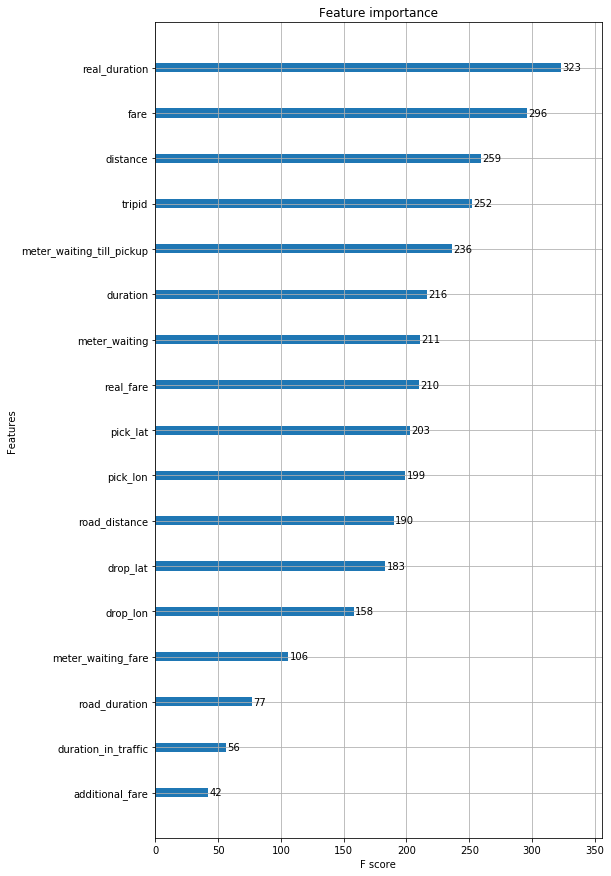

In [47]:
# plot feature importance using built-in function
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
# split data into X and y
X = train_x
y = train_y
# fit model no training data
model = XGBClassifier()
model.fit(X, y)
# plot feature importance
fig, ax = plt.subplots(figsize=(8, 15))
plot_importance(model,ax=ax)
pyplot.show()

In [48]:
"""
# use feature importance for feature selection, with fix for xgboost 1.0.2
from numpy import loadtxt
from numpy import sort
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score

# define custom class to fix bug in xgboost 1.0.2
class MyXGBClassifier(XGBClassifier):
    @property
    def coef_(self):
        return None

# split data into X and y
X = train_x
Y = train_y
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)
# fit model on all training data
model = MyXGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data and evaluate
predictions = model.predict(X_test)
#accuracy = accuracy_score(y_test, predictions)
accuracy=f1_score(y_test, predictions, average='macro')
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    predictions = selection_model.predict(select_X_test)
    #accuracy = accuracy_score(y_test, predictions)
    accuracy=f1_score(y_test, predictions, average='macro')
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))
#Thresh=0.048, n=5, Accuracy: 83.68% geo hash 3h
#Thresh=0.014, n=32, Accuracy: 83.71% no geo hash
#Accuracy: 84.38% Thresh=0.025, n=10, Accuracy: 85.09%
"""

'\n# use feature importance for feature selection, with fix for xgboost 1.0.2\nfrom numpy import loadtxt\nfrom numpy import sort\nfrom xgboost import XGBClassifier\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import accuracy_score\nfrom sklearn.feature_selection import SelectFromModel\nfrom sklearn.metrics import f1_score\n\n# define custom class to fix bug in xgboost 1.0.2\nclass MyXGBClassifier(XGBClassifier):\n    @property\n    def coef_(self):\n        return None\n\n# split data into X and y\nX = train_x\nY = train_y\n# split data into train and test sets\nX_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)\n# fit model on all training data\nmodel = MyXGBClassifier()\nmodel.fit(X_train, y_train)\n# make predictions for test data and evaluate\npredictions = model.predict(X_test)\n#accuracy = accuracy_score(y_test, predictions)\naccuracy=f1_score(y_test, predictions, average=\'macro\')\nprint("Accuracy: %.2f%%" % 

In [49]:
""""
from sklearn import preprocessing

x = ['additional_fare','meter_waiting_fare']
min_max_scaler = preprocessing.MinMaxScaler()
train_x[x] = min_max_scaler.fit_transform(train_x[x])
#x_scaled = pd.DataFrame(x_scaled)
test[x] = min_max_scaler.fit_transform(test[x])
"""

'"\nfrom sklearn import preprocessing\n\nx = [\'additional_fare\',\'meter_waiting_fare\']\nmin_max_scaler = preprocessing.MinMaxScaler()\ntrain_x[x] = min_max_scaler.fit_transform(train_x[x])\n#x_scaled = pd.DataFrame(x_scaled)\ntest[x] = min_max_scaler.fit_transform(test[x])\n'

In [50]:
test.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,road_distance,road_duration,duration_in_traffic,real_duration,real_fare,distance
0,213284604,10.5,924,42,2.4486,148,6.83454,79.8750,6.77490,79.8840,289.27,8.6,1320,840,882,276.3214,6.705702
1,213286352,10.5,4249,20,0.0000,91,6.91168,79.8723,6.55091,79.9706,1912.70,63.5,5040,4200,4229,1902.2000,41.558513
2,213293973,10.5,1552,255,2.6588,23,6.92145,79.8478,6.90539,79.8989,394.00,7.3,1560,1080,1297,380.8412,5.916678
3,213294622,10.5,462,16,0.0000,198,6.77433,79.9416,6.80401,79.9407,154.32,4.0,600,420,446,143.8200,3.301761
4,213298687,10.5,814,392,12.3692,69,6.97968,79.9130,6.98875,79.8914,147.47,3.0,540,360,422,124.6008,2.588542


In [51]:
"""

print("Before OverSampling, counts of label '1': {}".format(sum(train_y==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(train_y==0)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(train_x, train_y.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))
"""

'\n\nprint("Before OverSampling, counts of label \'1\': {}".format(sum(train_y==1)))\nprint("Before OverSampling, counts of label \'0\': {} \n".format(sum(train_y==0)))\n\nsm = SMOTE(random_state=2)\nX_train_res, y_train_res = sm.fit_sample(train_x, train_y.ravel())\n\nprint(\'After OverSampling, the shape of train_X: {}\'.format(X_train_res.shape))\nprint(\'After OverSampling, the shape of train_y: {} \n\'.format(y_train_res.shape))\n\nprint("After OverSampling, counts of label \'1\': {}".format(sum(y_train_res==1)))\nprint("After OverSampling, counts of label \'0\': {}".format(sum(y_train_res==0)))\n'

In [52]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, roc_auc_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler

X_train, X_test, y_train, y_test = train_test_split(
    train_x,
    train_y,
    test_size=0.33,
    shuffle=True,
    stratify=train_y,
    random_state=42
)
#sm = SMOTE(random_state=42,sampling_strategy=0.2)
#X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

#selection = SelectFromModel(XGBClassifier(),threshold=0.025, prefit=True)
#select_X_train = selection.transform(X_train_res)
#select_X_test = selection.transform(X_test)

#under = RandomUnderSampler(sampling_strategy=0.5)
#X_train_res, y_train_res = under.fit_sample(X_train, y_train)

X_train_res, y_train_res=X_train, y_train
#oversample = RandomOverSampler(sampling_strategy='minority')
#X_train_res, y_train_res = oversample.fit_resample(X_train, y_train)


#oversample = ADASYN(sampling_strategy=0.33)
#X_train_res, y_train_res = oversample.fit_resample(X_train, y_train)

In [53]:
X_train_res

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,road_distance,road_duration,duration_in_traffic,real_duration,real_fare,distance
15220,211375730,10.5,304.0,10.0,0.000000,27.0,7.21214,79.8460,7.21125,79.8379,70.23,1.2,300,180,294.0,59.730000,0.899017
700,189994545,10.5,3425.0,1000.0,0.000000,102.0,6.92043,79.8660,6.79404,79.8838,718.72,17.3,2940,2400,2425.0,708.220000,14.190649
4750,195417591,10.5,1049.0,315.0,18.364500,207.0,6.80737,79.8842,6.77362,79.8807,176.67,5.1,840,720,734.0,147.805500,3.772674
3444,193558059,10.5,1148.0,311.0,18.029299,145.0,6.88572,79.8707,6.90964,79.8881,169.76,4.2,900,600,837.0,141.230701,3.280834
10027,203661345,40.5,2089.0,383.0,0.000000,61.0,6.88701,79.9036,6.94747,79.8668,388.04,10.6,1980,1440,1706.0,347.540000,7.854809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9203,202374257,10.5,657.0,100.0,5.830000,23.0,7.30375,80.6365,7.29290,80.6344,118.98,2.3,540,360,557.0,102.650000,1.228497
5977,197471399,10.5,843.0,147.0,8.496600,88.0,7.19508,79.8534,7.21275,79.8422,162.41,3.1,600,480,696.0,143.413400,2.321009
16238,212491705,10.5,872.0,126.0,0.000000,135.0,6.82071,79.8916,6.83917,79.8861,216.12,6.1,900,720,746.0,205.620000,2.140593
7961,200581816,10.5,250.0,30.0,1.749000,10.0,7.28769,80.6283,7.30098,80.6355,98.81,1.8,360,240,220.0,86.561000,1.677638


In [54]:
"""
params = {'max_depth': 9,
 'min_child_weight': 5,
 'eta': 0.1,
 'subsample': 1.0,
 'colsample_bytree': 1.0,
 'objective': 'reg:linear',
 'validate_parameters': 1}
"""
#satify

"\nparams = {'max_depth': 9,\n 'min_child_weight': 5,\n 'eta': 0.1,\n 'subsample': 1.0,\n 'colsample_bytree': 1.0,\n 'objective': 'reg:linear',\n 'validate_parameters': 1}\n"

In [55]:
"""
dtrain_fin = xgb.DMatrix(train_x, label=train_y)
model_fin = xgb.train(
    params,
    dtrain_fin,
    num_boost_round=91
)
{'max_depth': 9,
 'min_child_weight': 5,
 'eta': 0.1,
 'subsample': 1.0,
 'colsample_bytree': 1.0,
 'objective': 'reg:linear',
 'validate_parameters': 1}
"""

"\ndtrain_fin = xgb.DMatrix(train_x, label=train_y)\nmodel_fin = xgb.train(\n    params,\n    dtrain_fin,\n    num_boost_round=91\n)\n{'max_depth': 9,\n 'min_child_weight': 5,\n 'eta': 0.1,\n 'subsample': 1.0,\n 'colsample_bytree': 1.0,\n 'objective': 'reg:linear',\n 'validate_parameters': 1}\n"

In [56]:
#"""
space={
    'max_depth': hp.quniform("max_depth", 3, 80, 1),
    'gamma': hp.uniform ('gamma', 0,9),
    'reg_alpha' : hp.quniform('reg_alpha', 1,180,1),
    'reg_lambda' : hp.uniform('reg_lambda', 0,1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
    'n_estimators': hp.choice('n_estimators', range(100, 1000, 20)),
    'seed': hp.choice('seed', range(0, 60, 5)),
    'learning_rate' : hp.choice('learning_rate', [0.005,0.01,0.05,0.1,0.3,0.5,0.7,0.9,1,1.2,1.4,1.6,1.8]),
    'objective' : 'binary:logistic',
    'nthread' : hp.choice('nthread', range(0,9)),
    'subsample' : hp.uniform ('subsample', 0,1),
    'scale_pos_weight': hp.uniform ('scale_pos_weight', 0,1)
    }
#"""

In [57]:
#"""
import lightgbm as lgb
from sklearn.metrics import precision_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import recall_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import f1_score
def objective(space):
    clf=XGBClassifier(
        max_depth = int(space['max_depth']),  
        gamma = space['gamma'],  
        reg_alpha = int(space['reg_alpha']),
        reg_lambda = space['reg_lambda'],  
        colsample_bytree = space['colsample_bytree'],  
        min_child_weight=int(space['min_child_weight']),  
        n_estimators =space['n_estimators'],
        seed = space['seed'],    
        learning_rate = space['learning_rate'],    
        objective = space['objective'],    
        nthread = space['nthread'],    
        subsample = space['subsample'],
        scale_pos_weight = space['scale_pos_weight']   
    )
    
    evaluation = [(X_train_res,y_train_res),(X_test,y_test)]
    
    clf.fit(X_train_res, y_train_res,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    #accuracy = accuracy_score(y_test, pred>0.5)
    #accuracy = clf.score(X_eval_H1, y_eval_H1N1)
    #accuracy=(precision_score(y_test, pred)+recall_score(y_test, pred))/2
    #accuracy=matthews_corrcoef(y_test, pred)
    #accuracy = clf.score(X_eval_H1, y_eval_H1N1)
    #accuracy=cohen_kappa_score(y_test, pred)
    accuracy=f1_score(y_test, pred, average='macro')
    print ("SCORE:", accuracy )
    return {'loss': -accuracy, 'status': STATUS_OK }
#"""

In [58]:
#"""tpe,anneal
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = anneal.suggest,
                        max_evals = 500,
                        trials = trials)
#                        """

SCORE:                                                 
0.8788146057505732                                     
SCORE:                                                                            
0.9020991356500264                                                                
SCORE:                                                                            
0.9160345739989416                                                                
SCORE:                                                                            
0.9193861351208326                                                                
SCORE:                                                                            
0.9167401658140766                                                                
SCORE:                                                                            
0.8819897689186805                                                                
SCORE:                                                    

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7b3e59aed0>],
      dtype=object)

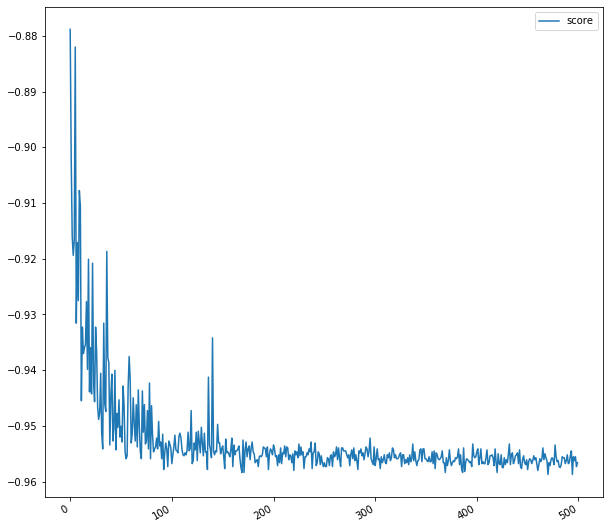

In [59]:
tpe_results=np.array([[x['result']['loss']] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,columns=['score'])
tpe_results_df.plot(subplots=True,figsize=(10, 10))

Text(0, 0.5, 'best_cumulative_score')

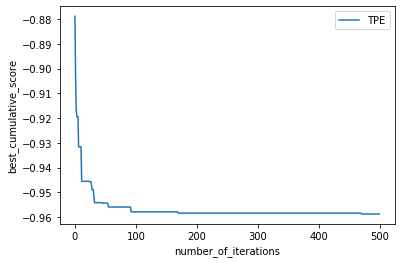

In [60]:
#"""
scores_df=pd.DataFrame(index=range(500))
scores_df['TPE']=tpe_results_df['score'].cummin()
#scores_df['Annealing']=sa_results_df['score'].cummin()

ax = scores_df.plot()

ax.set_xlabel("number_of_iterations")
ax.set_ylabel("best_cumulative_score")
#"""

In [61]:
print("The best hyperparameters of H1N1 are : ","\n")
print(best_hyperparams)
#0.8623368507346051 {'colsample_bytree': 0.5814604363769624, 'gamma': 3.4056907200527045, 'learning_rate': 2, 'max_depth': 25.0, 'min_child_weight': 2.0, 'n_estimators': 5, 'nthread': 5, 'reg_alpha': 2.0, 'reg_lambda': 0.4684030104810268, 'scale_pos_weight': 0.41712012015239697, 'seed': 6, 'subsample': 0.6446318136620117}
# acc 0.9571428571428572 {'colsample_bytree': 0.8941555699462487, 'gamma': 1.837187168025523, 'learning_rate': 3, 'max_depth': 54.0, 'min_child_weight': 6.0, 'n_estimators': 4, 'nthread': 6, 'reg_alpha': 2.0, 'reg_lambda': 0.8090918445712043, 'scale_pos_weight': 0.5149850044846055, 'seed': 2, 'subsample': 0.6963300985524179}
# acc 0.9578408890456871 {'colsample_bytree': 0.7991978433063185, 'gamma': 2.2959096556120704, 'learning_rate': 3, 'max_depth': 48.0, 'min_child_weight': 6.0, 'n_estimators': 39, 'nthread': 7, 'reg_alpha': 1.0, 'reg_lambda': 0.3269883810187581, 'scale_pos_weight': 0.8075658460028577, 'seed': 11, 'subsample': 0.9551498628192542}

The best hyperparameters of H1N1 are :  

{'colsample_bytree': 0.843840880844965, 'gamma': 6.087182759165802, 'learning_rate': 5, 'max_depth': 41.0, 'min_child_weight': 7.0, 'n_estimators': 25, 'nthread': 1, 'reg_alpha': 3.0, 'reg_lambda': 0.11638855596564728, 'scale_pos_weight': 0.7975374416459242, 'seed': 11, 'subsample': 0.7761393892278631}


Text(0, 0.5, 'best_cumulative_score')

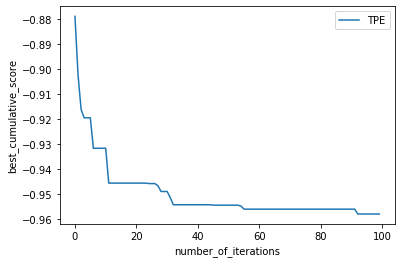

In [62]:
#"""
scores_df=pd.DataFrame(index=range(100))
#scores_df['Grid Search']=gs_results_df['score'].cummin()
#scores_df['Random Search']=rs_results_df['score'].cummin()
scores_df['TPE']=tpe_results_df['score'].cummin()
#scores_df['Annealing']=sa_results_df['score'].cummin()

ax = scores_df.plot()

ax.set_xlabel("number_of_iterations")
ax.set_ylabel("best_cumulative_score")
#"""

In [63]:
"""
space={
    'max_depth': hp.choice('max_depth', range(-1,-9,-1)),
    'gamma': hp.uniform ('gamma', 1,2),
    'reg_alpha' : hp.quniform('reg_alpha', 1,180,1),
    'reg_lambda' : hp.uniform('reg_lambda', 0,1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
    'min_child_weight' : hp.uniform('min_child_weight', 0, 10),
    'objective' : 'binary',
    'nthread' : hp.choice('nthread', range(0,9)),
    'subsample' : hp.uniform ('subsample', 0,1),
    'subsample_freq' : hp.quniform ('subsample_freq', 0,5,1),
    'scale_pos_weight': hp.uniform ('scale_pos_weight', 0,1),
    #'num_leaves': hp.quniform('num_leaves', 1,180,1),
    'learning_rate' : hp.choice('learning_rate', [0.0005,0.001,0.005,0.01,0.05,0.1,0.3,0.5,0.7,0.9,1,1.2,1.4,1.6,1.8]),
    'max_bin': hp.quniform('max_bin', 150,400,1),
    #'subsample_for_bin': hp.choice('subsample_for_bin', range(0, 1000, 50)),
    'seed': hp.quniform('seed', 1,180,1),
    'min_split_gain': hp.choice('min_split_gain', [0.0005,0.001,0.005,0.01,0.05,0.1,0.3,0.5,0.7,0.9,1,1.2,1.4,1.6,1.8]),
    'min_child_samples': hp.quniform('min_child_samples', 1,100,1),
    'n_estimators': hp.choice('n_estimators', range(100, 1000, 20)),
    'metric' : 'binary_error',
    'boosting_type' : 'gbdt'
    }
"""

"\nspace={\n    'max_depth': hp.choice('max_depth', range(-1,-9,-1)),\n    'gamma': hp.uniform ('gamma', 1,2),\n    'reg_alpha' : hp.quniform('reg_alpha', 1,180,1),\n    'reg_lambda' : hp.uniform('reg_lambda', 0,1),\n    'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),\n    'min_child_weight' : hp.uniform('min_child_weight', 0, 10),\n    'objective' : 'binary',\n    'nthread' : hp.choice('nthread', range(0,9)),\n    'subsample' : hp.uniform ('subsample', 0,1),\n    'subsample_freq' : hp.quniform ('subsample_freq', 0,5,1),\n    'scale_pos_weight': hp.uniform ('scale_pos_weight', 0,1),\n    #'num_leaves': hp.quniform('num_leaves', 1,180,1),\n    'learning_rate' : hp.choice('learning_rate', [0.0005,0.001,0.005,0.01,0.05,0.1,0.3,0.5,0.7,0.9,1,1.2,1.4,1.6,1.8]),\n    'max_bin': hp.quniform('max_bin', 150,400,1),\n    #'subsample_for_bin': hp.choice('subsample_for_bin', range(0, 1000, 50)),\n    'seed': hp.quniform('seed', 1,180,1),\n    'min_split_gain': hp.choice('min_split_gain

In [64]:
"""
import lightgbm as lgb
from sklearn.metrics import precision_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import recall_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import f1_score
def objective(space):
    clf=lgb.LGBMClassifier(
        max_depth = int(space['max_depth']),  
        gamma = space['gamma'],  
        reg_alpha = int(space['reg_alpha']),
        reg_lambda = space['reg_lambda'],  
        colsample_bytree = space['colsample_bytree'],  
        min_child_weight=space['min_child_weight'],
        objective = 'binary', 
        nthread = space['nthread'],    
        subsample = space['subsample'],  
        subsample_freq = int(space['subsample_freq']),
        scale_pos_weight = space['scale_pos_weight'],
        #num_leaves = int(space['num_leaves']),  
        learning_rate = space['learning_rate'],
        max_bin = int(space['max_bin']),
        #subsample_for_bin = int(space['subsample_for_bin']), 
        seed = int(space['seed']), 
        min_split_gain = space['min_split_gain'],
        min_child_samples = int(space['min_child_samples']),       
        n_estimators =space['n_estimators'], 
        metric = 'binary_error',
        boosting_type = 'gbdt'
    )
    
    evaluation = [(X_train_res, y_train_res),(X_test,y_test)]
    
    clf.fit(X_train_res, y_train_res,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    #accuracy=(precision_score(y_test, pred)+recall_score(y_test, pred))/2
    #accuracy=matthews_corrcoef(y_test, pred)
    #accuracy = clf.score(X_eval_H1, y_eval_H1N1)
    #accuracy=cohen_kappa_score(y_test, pred)
    #accuracy=f1_score(y_test, pred, average='macro')
    print ("SCORE:", accuracy )
    return {'loss': -accuracy, 'status': STATUS_OK }
"""

'\nimport lightgbm as lgb\nfrom sklearn.metrics import precision_score\nfrom sklearn.metrics import matthews_corrcoef\nfrom sklearn.metrics import recall_score\nfrom sklearn.metrics import cohen_kappa_score\nfrom sklearn.metrics import f1_score\ndef objective(space):\n    clf=lgb.LGBMClassifier(\n        max_depth = int(space[\'max_depth\']),  \n        gamma = space[\'gamma\'],  \n        reg_alpha = int(space[\'reg_alpha\']),\n        reg_lambda = space[\'reg_lambda\'],  \n        colsample_bytree = space[\'colsample_bytree\'],  \n        min_child_weight=space[\'min_child_weight\'],\n        objective = \'binary\', \n        nthread = space[\'nthread\'],    \n        subsample = space[\'subsample\'],  \n        subsample_freq = int(space[\'subsample_freq\']),\n        scale_pos_weight = space[\'scale_pos_weight\'],\n        #num_leaves = int(space[\'num_leaves\']),  \n        learning_rate = space[\'learning_rate\'],\n        max_bin = int(space[\'max_bin\']),\n        #subsample_fo

In [65]:
"""
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)
"""

'\ntrials = Trials()\n\nbest_hyperparams = fmin(fn = objective,\n                        space = space,\n                        algo = tpe.suggest,\n                        max_evals = 100,\n                        trials = trials)\n'

In [66]:
"""
print("The best hyperparameters of H1N1 are : ","\n")
print(best_hyperparams)
"""
#0.9601648351648352
#{'colsample_bytree': 0.7924063023680942, 'gamma': 4.933266661369982, 'learning_rate': 2, 'max_depth': 18.0, 'min_child_weight': 5.0, 'n_estimators': 33, 'nthread': 7, 'reg_alpha': 1.0, 'reg_lambda': 0.6043391015782976, 'scale_pos_weight': 0.9957320086193597, 'seed': 7, 'subsample': 0.8526840580155188}
#0.9341071428571428
#{'colsample_bytree': 0.915357189936755, 'gamma': 1.3224881224885185, 'learning_rate': 6, 'max_bin': 397.0, 'max_depth': 0, 'min_child_samples': 46.0, 'min_child_weight': 4.551938805671117, 'min_split_gain': 5, 'n_estimators': 11, 'nthread': 1, 'reg_alpha': 1.0, 'reg_lambda': 0.7284339083652174, 'scale_pos_weight': 0.9649180521358363, 'seed': 120.0, 'subsample': 0.9765199208086601, 'subsample_freq': 1.0}
#0.6186581254438771 MCC
#0.6335225343448203
#{'colsample_bytree': 0.639350369041687, 'gamma': 1.433573066486934, 'learning_rate': 8, 'max_bin': 295.0, 'max_depth': 7, 'min_child_samples': 73.0, 'min_child_weight': 2.951579957416372, 'min_split_gain': 4, 'n_estimators': 14, 'nthread': 7, 'reg_alpha': 1.0, 'reg_lambda': 0.9200866516787046, 'scale_pos_weight': 0.6738257922562352, 'seed': 7.0, 'subsample': 0.974466664546171, 'subsample_freq': 0.0}
#0.8390855590729108 F1  {'colsample_bytree': 0.7786351476782603, 'gamma': 1.7865613927168917, 'learning_rate': 5, 'max_bin': 349.0, 'max_depth': 7, 'min_child_samples': 69.0, 'min_child_weight': 7.58036887133503, 'min_split_gain': 10, 'n_estimators': 12, 'nthread': 1, 'reg_alpha': 1.0, 'reg_lambda': 0.733697400678615, 'scale_pos_weight': 0.41908236788164377, 'seed': 59.0, 'subsample': 0.7451477557195242, 'subsample_freq': 0.0}

'\nprint("The best hyperparameters of H1N1 are : ","\n")\nprint(best_hyperparams)\n'

In [67]:
"""
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier
import lightgbm as lgb
rate=[0.005,0.01,0.05,0.1,0.3,0.5,0.7,0.9,1,1.2,1.4,1.6,1.8]
model = lgb.LGBMClassifier(
    boosting_type = 'gbdt',
    max_depth = -1,
    objective = 'binary',
    nthread = 3, # Updated from nthread
    num_leaves = 64,
    learning_rate = 0.05,
    max_bin = 512,
    subsample_for_bin = 200,
    subsample = 1,
    subsample_freq = 1,
    colsample_bytree = 0.8,
    reg_alpha = 5,
    reg_lambda = 10,
    min_split_gain = 0.5,
    min_child_weight = 1,
    min_child_samples = 5,
    scale_pos_weight = 1,
    num_class = 1, 
)
#model.fit(train_x,train_y)
"""

"\nfrom numpy import mean\nfrom sklearn.datasets import make_classification\nfrom sklearn.model_selection import cross_val_score\nfrom sklearn.model_selection import RepeatedStratifiedKFold\nfrom xgboost import XGBClassifier\nimport lightgbm as lgb\nrate=[0.005,0.01,0.05,0.1,0.3,0.5,0.7,0.9,1,1.2,1.4,1.6,1.8]\nmodel = lgb.LGBMClassifier(\n    boosting_type = 'gbdt',\n    max_depth = -1,\n    objective = 'binary',\n    nthread = 3, # Updated from nthread\n    num_leaves = 64,\n    learning_rate = 0.05,\n    max_bin = 512,\n    subsample_for_bin = 200,\n    subsample = 1,\n    subsample_freq = 1,\n    colsample_bytree = 0.8,\n    reg_alpha = 5,\n    reg_lambda = 10,\n    min_split_gain = 0.5,\n    min_child_weight = 1,\n    min_child_samples = 5,\n    scale_pos_weight = 1,\n    num_class = 1, \n)\n#model.fit(train_x,train_y)\n"

In [68]:
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier
import lightgbm as lgb
rate=[0.0005,0.001,0.005,0.01,0.05,0.1,0.3,0.5,0.7,0.9,1,1.2,1.4,1.6,1.8]
model = XGBClassifier(
        max_depth = int(best_hyperparams['max_depth']),  
        gamma = best_hyperparams['gamma'],  
        reg_alpha = int(best_hyperparams['reg_alpha']),
        reg_lambda = best_hyperparams['reg_lambda'],  
        colsample_bytree = best_hyperparams['colsample_bytree'],  
        min_child_weight=int(best_hyperparams['min_child_weight']),  
        n_estimators =100+20*best_hyperparams['n_estimators'],
        seed = 5*best_hyperparams['seed'],    
        learning_rate = rate[best_hyperparams['learning_rate']],    
        objective = 'binary:logistic',    
        nthread = best_hyperparams['nthread'],    
        subsample = best_hyperparams['subsample'],
        scale_pos_weight = best_hyperparams['scale_pos_weight'] 
)
#model.fit(train_x,train_y)

In [69]:
X_train_res.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,road_distance,road_duration,duration_in_traffic,real_duration,real_fare,distance
15220,211375730,10.5,304.0,10.0,0.000000,27.0,7.21214,79.8460,7.21125,79.8379,70.23,1.2,300,180,294.0,59.730000,0.899017
700,189994545,10.5,3425.0,1000.0,0.000000,102.0,6.92043,79.8660,6.79404,79.8838,718.72,17.3,2940,2400,2425.0,708.220000,14.190649
4750,195417591,10.5,1049.0,315.0,18.364500,207.0,6.80737,79.8842,6.77362,79.8807,176.67,5.1,840,720,734.0,147.805500,3.772674
3444,193558059,10.5,1148.0,311.0,18.029299,145.0,6.88572,79.8707,6.90964,79.8881,169.76,4.2,900,600,837.0,141.230701,3.280834
10027,203661345,40.5,2089.0,383.0,0.000000,61.0,6.88701,79.9036,6.94747,79.8668,388.04,10.6,1980,1440,1706.0,347.540000,7.854809


In [70]:
model.fit(X_train_res, y_train_res)
pred = model.predict(X_test)

In [71]:
from sklearn.metrics import confusion_matrix
x = confusion_matrix(y_test, pred).ravel()
x
#array([ 211,  293,   15, 5081]) 10
#array([ 279,  225,   41, 5055]) 1
#array([ 357,  147,  250, 4846]) 0.1
#array([ 234,  270,  114, 4982]) rate = 0.1
#array([ 196,  308,   73, 5023]) rate = 0.1
#array([ 271,  233,   66, 5030]) 
#array([ 248,  256,   38, 5058])
#array([ 313,  191,   92, 5004]) smote acc : 0.9612 rec : 0.9746 pre : 0.9491
#array([ 216,  288,   27, 5069]) lightboost
#array([ 298,  206,   70, 5026]) lightboost kappa
#array([ 335,  220,   67, 5047]) drop time
#array([ 345,  210,   81, 5033]) F1 geohash lightboost need sub & smot acc
#array([ 318,  237,   41, 5073]) geohash XGboost
#array([ 352,  203,   69, 5045]) tun geohash XGboost acc need sub & smot
#array([ 334,  221,   48, 5066]) tun geohash XGboost F1 
#array([ 347,  208,   64, 5050]) 5669 F1 no geohash realduration no smot null mean onehot(pick hour,week) no feature selection
#array([ 360,  195,   40, 5074]) 5669 accuracy_score no geohash realduration no smot null mean onehot(pick hour,week) no feature selection
#array([ 326,  229,   26, 5088]) 5669 F1 no geohash realduration no smot null mean no feature selection
#array([ 356,  199,   34, 5080]) 5669 accuracy_score no geohash realduration no smot null mean no feature selection
#array([ 390,  165,   98, 5016]) 5669 F1 no geohash realduration no smot null mean group (pick hour,week) no feature selection
#array([ 376,  179,   60, 5054]) 5669 F1 no geohash realduration no smot null mean of lable no feature selection

#array([ 392,  163,   80, 5034])
#array([ 367,  188,   46, 5068])
#array([ 368,  187,   42, 5072])acc aucpr

array([ 351,  204,   31, 5083])

In [72]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, pred)

0.9585464808608221

In [73]:
from sklearn.metrics import recall_score
recall_score(y_test, pred)

0.9939382088384826

In [74]:
from sklearn.metrics import precision_score
precision_score(y_test, pred)

0.9614147909967846

In [75]:
model1 = XGBClassifier(
        max_depth = int(best_hyperparams['max_depth']),  
        gamma = best_hyperparams['gamma'],  
        reg_alpha = int(best_hyperparams['reg_alpha']),
        reg_lambda = best_hyperparams['reg_lambda'],  
        colsample_bytree = best_hyperparams['colsample_bytree'],  
        min_child_weight=int(best_hyperparams['min_child_weight']),  
        n_estimators =100+20*best_hyperparams['n_estimators'],
        seed = 5*best_hyperparams['seed'],    
        learning_rate = rate[best_hyperparams['learning_rate']],    
        objective = 'binary:logistic',    
        nthread = best_hyperparams['nthread'],    
        subsample = best_hyperparams['subsample'],
        scale_pos_weight = best_hyperparams['scale_pos_weight']
)
model1.fit(train_x,train_y)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.843840880844965,
              gamma=6.087182759165802, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.1, max_delta_step=0,
              max_depth=41, min_child_weight=7, missing=nan,
              monotone_constraints=None, n_estimators=600, n_jobs=1, nthread=1,
              num_parallel_tree=1, objective='binary:logistic', random_state=55,
              reg_alpha=3, reg_lambda=0.11638855596564728,
              scale_pos_weight=0.7975374416459242, seed=55,
              subsample=0.7761393892278631, tree_method=None,
              validate_parameters=False, verbosity=None)

In [76]:
# make predictions for test data
pred = model1.predict(test)
pred

array([1, 1, 1, ..., 1, 1, 1])

In [77]:
#Create submission file
submission = pd.DataFrame({
        "tripid": test.tripid,
        "prediction": pred
})

submission.to_csv('sample_submission.csv',index=False)
submission.head()

,tripid,prediction
0,213284604,1
1,213286352,1
2,213293973,1
3,213294622,1
4,213298687,1
